In [1]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import string
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
import re
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Conv1D
from tensorflow.keras.layers import Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate,GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.models import Sequential

from gensim.models import KeyedVectors

In [2]:
df_main = pd.read_csv('df_main.csv')
df_main.shape

(160000, 3)

In [3]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
embed_size = 300 # how big is each word vector
max_features = 50000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a question to use

question_words = list()
lines = df_main['question_text'].values.tolist()

for line in lines:   
    tokens = word_tokenize(line)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word    
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words    
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    question_words.append(words)

In [5]:
import gensim
EMBEDDING_DIM = 100
# train word2vec model
model = gensim.models.Word2Vec(sentences=question_words, size=EMBEDDING_DIM, window=1, workers=4, min_count=1, sg=0)
# vocab size
words = list(model.wv.vocab)
print('Vocabulary size: %d' % len(words))

Vocabulary size: 58951


In [6]:
###filename = 'embedding_word2vec_cbow.txt'
###model.wv.save_word2vec_format(filename, binary=False)

In [7]:
model.wv.most_similar('people')

[('cops', 0.8503865003585815),
 ('foreigners', 0.8494721055030823),
 ('westerners', 0.8480013012886047),
 ('others', 0.8465684652328491),
 ('ones', 0.8410245180130005),
 ('folks', 0.8370542526245117),
 ('teenagers', 0.8263778686523438),
 ('indonesians', 0.8235374093055725),
 ('atheists', 0.8222283720970154),
 ('humans', 0.8219000697135925)]

In [5]:
import os

embeddings_index = {}
f = open('embedding_word2vec_cbow.txt', encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()

In [6]:
X_train, X_test,y_train, y_test = train_test_split(df_main['question_text'],df_main.target, test_size = 0.2)

In [7]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [8]:
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(question_words)
sequences = tokenizer_obj.texts_to_sequences(question_words)
# pad sequences
word_index = tokenizer_obj.word_index
print('Found %s unique tokens.' % len(word_index))

Found 58951 unique tokens.


In [9]:
review_pad = pad_sequences(sequences, maxlen=100)
sentiment =  df_main['target'].values
print('Shape of review tensor:', review_pad.shape)
print('Shape of sentiment tensor:', sentiment.shape)

Shape of review tensor: (160000, 100)
Shape of sentiment tensor: (160000,)


In [10]:
# split the data into a training set and a validation set
indices = np.arange(review_pad.shape[0])
np.random.shuffle(indices)
review_pad = review_pad[indices]
sentiment = sentiment[indices]
num_validation_samples = int(0.2 * review_pad.shape[0])

In [11]:
X_train_pad = review_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
X_test_pad = review_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

In [12]:
print('Shape of X_train_pad tensor:', X_train_pad.shape)
print('Shape of y_train tensor:', y_train.shape)

print('Shape of X_test_pad tensor:', X_test_pad.shape)
print('Shape of y_test tensor:', y_test.shape)

Shape of X_train_pad tensor: (128000, 100)
Shape of y_train tensor: (128000,)
Shape of X_test_pad tensor: (32000, 100)
Shape of y_test tensor: (32000,)


In [13]:
EMBEDDING_DIM =100
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [14]:
from keras.initializers import Constant



In [15]:
model = Sequential()
model.add(Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=100,
                            trainable=False))
model.add(Bidirectional(LSTM(300,return_sequences=True)))
model.add(Bidirectional(LSTM(300,return_sequences=True)))
model.add(Bidirectional(LSTM(300,return_sequences=True)))
model.add(GlobalMaxPool1D())
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          5895200   
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 600)          962400    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 600)          2162400   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 600)          2162400   
_________________________________________________________________
global_max_pooling1d (Global (None, 600)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                9616      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0

In [16]:
model.fit(X_train_pad, y_train, batch_size=32, epochs=10, verbose=1)

Epoch 1/10
4000/4000 [==============================] - 844s 211ms/step - loss: 0.3781 - accuracy: 0.8414
Epoch 2/10
4000/4000 [==============================] - 844s 211ms/step - loss: 0.3685 - accuracy: 0.8570
Epoch 3/10
4000/4000 [==============================] - 843s 211ms/step - loss: 0.3274 - accuracy: 0.8691
Epoch 4/10
4000/4000 [==============================] - 844s 211ms/step - loss: 0.3183 - accuracy: 0.8727
Epoch 5/10
4000/4000 [==============================] - 842s 211ms/step - loss: 0.3038 - accuracy: 0.8794
Epoch 6/10
4000/4000 [==============================] - 844s 211ms/step - loss: 0.2898 - accuracy: 0.8861
Epoch 7/10
4000/4000 [==============================] - 843s 211ms/step - loss: 0.2735 - accuracy: 0.8932
Epoch 8/10
4000/4000 [==============================] - 843s 211ms/step - loss: 0.2490 - accuracy: 0.9036
Epoch 9/10
4000/4000 [==============================] - 844s 211ms/step - loss: 0.2156 - accuracy: 0.9181
Epoch 10/10
4000/4000 [=======================

In [23]:
preds = model.predict(X_test_pad,batch_size=32)

In [24]:
print(len(preds))

32000


In [25]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [26]:
print(preds)

[[9.9295044e-01]
 [1.7923707e-02]
 [9.3525922e-04]
 ...
 [9.8640209e-01]
 [7.7825245e-03]
 [1.9705540e-01]]


In [27]:
def line_search_f1_score(y_score, y_test):
    max_f1_score = 0
    opt_threshold = 0
    for threshold in [i*0.01 for i in range(100)]:
        y_preds = y_score > threshold
        score = f1_score(y_preds, y_test)
        if max_f1_score < score:
            max_f1_score = score
            opt_threshold = threshold
    return max_f1_score, opt_threshold

In [28]:
max_f1_score, threshold = line_search_f1_score(preds, y_test)

In [29]:
print(max_f1_score, threshold)

0.8708411942622705 0.33


In [30]:
predictions = [1 if x>=0.33 else 0 for x in preds]

In [31]:
cf_matrix = confusion_matrix(predictions, y_test)

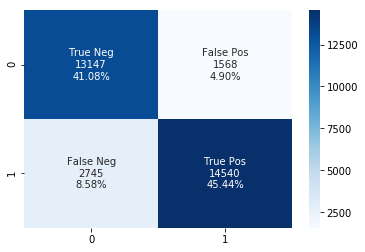

In [32]:
import seaborn as sns
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [33]:
print(accuracy_score(predictions, y_test))

0.86521875


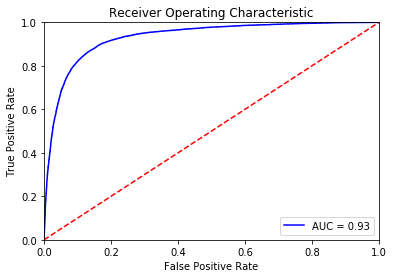

In [34]:
import sklearn.metrics as metrics
#preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [ ]:

from sklearn.metrics import classification_report

clf_report = classification_report(y_test,
                                   predictions,
                                   labels=[0,1],
                                   output_dict=True)

fig, ax = plt.subplots(figsize=(12,12)) 
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True,ax=ax,square = False)